In [118]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras import layers
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from numpy import expand_dims
import cv2
import numpy as np
import os
import pandas as pd
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [26]:
!git clone https://github.com/r-narula/Bounding-Box.git

fatal: destination path 'Bounding-Box' already exists and is not an empty directory.


In [27]:
# extract the data 
!ls Bounding-Box

airplanes  Final.csv


In [106]:
# Hyper parameters
INIT_LR = 1e-4
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [29]:
## Now we are extracting the data ..
IMAGES_Folder = "Bounding-Box/airplanes/"
annotations_path = "Bounding-Box/Final.csv"

In [30]:
# Converting to a list of tuples
data = pd.read_csv(annotations_path)
data = data[["path","x_1","y_1","x_2","y_2"]]
records = data.to_records(index=False)
list_result = list(records)
print(list_result)

[('image_0001.jpg', 30, 137, 49, 349), ('image_0002.jpg', 35, 153, 59, 342), ('image_0003.jpg', 36, 135, 47, 331), ('image_0004.jpg', 24, 141, 47, 342), ('image_0005.jpg', 18, 146, 48, 339), ('image_0006.jpg', 24, 126, 48, 344), ('image_0007.jpg', 23, 122, 49, 344), ('image_0008.jpg', 29, 119, 51, 344), ('image_0009.jpg', 29, 137, 50, 344), ('image_0010.jpg', 32, 106, 55, 335), ('image_0011.jpg', 35, 130, 58, 344), ('image_0012.jpg', 25, 122, 49, 344), ('image_0013.jpg', 31, 146, 48, 344), ('image_0014.jpg', 37, 121, 55, 349), ('image_0015.jpg', 39, 163, 61, 353), ('image_0016.jpg', 54, 137, 59, 327), ('image_0017.jpg', 37, 143, 62, 347), ('image_0018.jpg', 33, 147, 57, 348), ('image_0019.jpg', 33, 146, 51, 341), ('image_0020.jpg', 31, 165, 45, 345), ('image_0021.jpg', 28, 129, 48, 347), ('image_0022.jpg', 30, 130, 49, 344), ('image_0023.jpg', 23, 121, 50, 341), ('image_0024.jpg', 25, 106, 48, 344), ('image_0025.jpg', 31, 140, 56, 342), ('image_0026.jpg', 30, 127, 59, 337), ('image_002

In [90]:
targets = []
data = []
filenames = []
for i in range(800):
    # Bring in each image and then convert to array and store in data

    img_path = os.path.join(IMAGES_Folder,list_result[i][0])
    image = cv2.imread(img_path)
    (h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
    startX = float(list_result[i][3]) / w
    startY = float(list_result[i][1]) / h
    endX = float(list_result[i][4]) / w
    endY = float(list_result[i][2]) / h
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(list_result[i][0])

    # appending the target coordinate (x1 y1 x2 y2)
    # targets.append((list_result[i][3]/img.size[0],list_result[i][1]/img.size[1],list_result[i][4]/img.size[0],list_result[i][2]/img.size[1]))
print(targets)

[(0.12311557788944724, 0.18292682926829268, 0.8768844221105527, 0.8353658536585366), (0.14713216957605985, 0.19021739130434784, 0.8528678304239401, 0.8315217391304348), (0.11959287531806616, 0.21818181818181817, 0.8422391857506362, 0.8181818181818182), (0.11959287531806616, 0.1411764705882353, 0.8702290076335878, 0.8294117647058824), (0.12151898734177215, 0.10227272727272728, 0.8582278481012658, 0.8295454545454546), (0.12213740458015267, 0.16326530612244897, 0.8753180661577609, 0.8571428571428571), (0.12531969309462915, 0.1554054054054054, 0.8797953964194374, 0.8243243243243243), (0.1291139240506329, 0.19463087248322147, 0.8708860759493671, 0.7986577181208053), (0.12755102040816327, 0.18012422360248448, 0.8775510204081632, 0.8509316770186336), (0.1385390428211587, 0.23357664233576642, 0.8438287153652393, 0.7737226277372263), (0.14536340852130325, 0.21604938271604937, 0.8621553884711779, 0.8024691358024691), (0.12342569269521411, 0.16233766233766234, 0.8664987405541562, 0.79220779220779

In [91]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [98]:
vgg = VGG16(weights="imagenet", include_top=False,	input_tensor=layers.Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = layers.Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [101]:
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [107]:
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Epoch 1/5
23/23 [==============================] - 256s 11s/step - loss: 0.0033 - val_loss: 9.2428e-04
Epoch 2/5
23/23 [==============================] - 254s 11s/step - loss: 0.0011 - val_loss: 6.9572e-04
Epoch 3/5
23/23 [==============================] - 254s 11s/step - loss: 7.8778e-04 - val_loss: 6.1644e-04
Epoch 4/5
23/23 [==============================] - 254s 11s/step - loss: 6.0618e-04 - val_loss: 5.5712e-04
Epoch 5/5
23/23 [==============================] - 260s 11s/step - loss: 5.1755e-04 - val_loss: 5.3982e-04


In [150]:
!wget https://images.unsplash.com/photo-1529074963764-98f45c47344b?ixid=MXwxMjA3fDB8MHxzZWFyY2h8Mnx8YWVyb3BsYW5lfGVufDB8fDB8&ixlib=rb-1.2.1&w=1000&q=80

--2021-02-11 18:53:37--  https://images.unsplash.com/photo-1529074963764-98f45c47344b?ixid=MXwxMjA3fDB8MHxzZWFyY2h8Mnx8YWVyb3BsYW5lfGVufDB8fDB8
Resolving images.unsplash.com (images.unsplash.com)... 151.101.38.208, 2a04:4e42:9::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.38.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1718026 (1.6M) [image/jpeg]
Saving to: ‘photo-1529074963764-98f45c47344b?ixid=MXwxMjA3fDB8MHxzZWFyY2h8Mnx8YWVyb3BsYW5lfGVufDB8fDB8’

photo-1529074963764 100%[===================>]   1.64M  --.-KB/s    in 0.04s   

2021-02-11 18:53:37 (39.1 MB/s) - ‘photo-1529074963764-98f45c47344b?ixid=MXwxMjA3fDB8MHxzZWFyY2h8Mnx8YWVyb3BsYW5lfGVufDB8fDB8’ saved [1718026/1718026]



In [151]:
!mv photo-1529074963764-98f45c47344b\?ixid\=MXwxMjA3fDB8MHxzZWFyY2h8Mnx8YWVyb3BsYW5lfGVufDB8fDB8 airplane.jpg

[[0.18579581 0.28720963 0.8614945  0.7462795 ]]
111 112 516 292


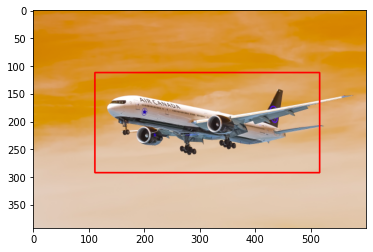

In [149]:
startX = 0
startY = 0 
endX = 0
endY = 0
imagePath = "airplane.jpg"
image = load_img(imagePath,target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)
print(preds)
(startX, startY, endX, endY) = preds[0]
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX,startY,endX,endY)
# # draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),(255, 0, 0), 2)
# # show the output image
plt.imshow(image)